In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.utils.data
from torch.nn import functional as F
import math
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from torch.autograd import Variable
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import scipy.io as sio
import pdb

#Wireless Parameters
N_t = 64
N_r = 16
latent_dim = 35

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

class _ConvNd(Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding, groups, bias):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def __repr__(self):
        s = ('{name}({in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)


class Conv2d(_ConvNd):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias)

    def forward(self, input):
        return conv2d_same_padding(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)


# custom con2d, because pytorch don't have "padding='same'" option.
def conv2d_same_padding(input, weight, bias=None, stride=1, padding=1, dilation=1, groups=1):

    input_rows = input.size(2)
    filter_rows = weight.size(2)
    effective_filter_size_rows = (filter_rows - 1) * dilation[0] + 1
    out_rows = (input_rows + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_rows - 1) * stride[0] + effective_filter_size_rows - input_rows)
    padding_rows = max(0, (out_rows - 1) * stride[0] + (filter_rows - 1) * dilation[0] + 1 - input_rows)
    rows_odd = (padding_rows % 2 != 0)
    # same for padding_cols
    input_cols = input.size(3)
    filter_cols = weight.size(3)
    effective_filter_size_cols = (filter_cols - 1) * dilation[0] + 1
    out_cols = (input_cols + stride[0] - 1) // stride[0]
    padding_needed = max(0, (out_cols - 1) * stride[0] + effective_filter_size_cols - input_cols)
    padding_cols = max(0, (out_cols - 1) * stride[0] + (filter_cols - 1) * dilation[0] + 1 - input_cols)
    cols_odd = (padding_cols % 2 != 0)
    if rows_odd or cols_odd:
        input = F.pad(input, [0, int(cols_odd), 0, int(rows_odd)])
    return F.conv2d(input, weight, bias, stride, padding=(padding_rows // 2, padding_cols // 2),dilation=dilation, groups=groups)
    
dft_basis = sio.loadmat("../CS-GAN-21_22/data/dft_basis.mat")
A_T = dft_basis['A1']/np.sqrt(N_t)
A_R = dft_basis['A2']/np.sqrt(N_r)

def fft_op(H_extracted):
    for i in range(H_extracted.shape[0]):
        H_extracted[i] = np.transpose(np.matmul(np.matmul(A_R.conj().T,H_extracted[i].T,dtype='complex64'),A_T))
    return H_extracted

In [11]:
LOS_NN = torch.nn.Sequential(
    Conv2d(2,16,3,stride=2),
    torch.nn.LeakyReLU(0.2,inplace=True),
    torch.nn.Dropout(0.25),
    Conv2d(16,32,3,stride=2),
    torch.nn.ZeroPad2d(padding=(0,1,0,1)),
    torch.nn.BatchNorm2d(32,momentum=0.8),
    torch.nn.LeakyReLU(0.2,inplace=True),
    torch.nn.Dropout(0.25),
    Conv2d(32,64,3,stride=2),
    torch.nn.BatchNorm2d(64,momentum=0.8),
    torch.nn.LeakyReLU(0.2,inplace=True),
    torch.nn.Dropout(0.25),
    Conv2d(64,128,3,stride=1),
    torch.nn.BatchNorm2d(128,momentum=0.8),
    torch.nn.LeakyReLU(0.2,inplace=True),
    torch.nn.Dropout(0.25),
    torch.nn.Flatten(),
    torch.nn.Linear(3456,1),
    torch.nn.Sigmoid(),
)
LOS_NN = LOS_NN.type(dtype) 
LOS_NN.load_state_dict(torch.load('checkpoints/LOS_NN/LOS_NN_2/LOS_NN_2.pt'))
LOS_NN.eval()

Sequential(
  (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Dropout(p=0.25, inplace=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (4): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.2, inplace=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (14): LeakyReLU(negative_slope=0.2, inplace=True)
  (15): Dropout(p=0.25, inplace=False)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=3456, out_features

In [3]:
H_org_A = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_A_ULA_test.mat")
H_ex_A = H_org_A['hest']
H_extracted_A = np.transpose(copy.deepcopy(H_ex_A),(2,1,0))
H_org_B = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_B_ULA_test.mat")
H_ex_B = H_org_B['hest']
H_extracted_B = np.transpose(copy.deepcopy(H_ex_B),(2,1,0))
H_org_C = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_C_ULA_test.mat")
H_ex_C = H_org_C['hest']
H_extracted_C = np.transpose(copy.deepcopy(H_ex_C),(2,1,0))
H_org_D = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_D_ULA_test.mat")
H_ex_D = H_org_D['hest']
H_extracted_D = np.transpose(copy.deepcopy(H_ex_D),(2,1,0))
H_org_E = sio.loadmat("../CS-GAN-21_22/data/H_16x64_MIMO_CDL_E_ULA_test.mat")
H_ex_E = H_org_E['hest']
H_extracted_E = np.transpose(copy.deepcopy(H_ex_E),(2,1,0))

H_extracted = np.concatenate([H_extracted_A,H_extracted_B,H_extracted_C,H_extracted_D,H_extracted_E],axis=0)
H_ex = np.concatenate([H_ex_A,H_ex_B,H_ex_C,H_ex_D,H_ex_E],axis=2)

In [4]:
size = int(H_extracted.shape[0]/5)
CDL_NLOS = np.zeros((3*size,1))
CDL_LOS = np.ones((2*size,1))
CDL = np.concatenate((CDL_NLOS,CDL_LOS),axis=0)

alpha = 0.25
N_p = int(alpha*N_t)
M = N_p*N_r
qpsk_constellation = (1/np.sqrt(2))*np.array([1+1j,1-1j,-1+1j,-1-1j])
identity = np.identity(N_p)
A_T_R = np.kron(A_T.conj(),A_R)
A_T_R_real = dtype(np.real(A_T_R))
A_T_R_imag = dtype(np.imag(A_T_R))
mb_size = 1

N_s = N_r
Nbit_t = 6
Nbit_r = 2
angles_t = np.linspace(0,2*np.pi,2**Nbit_t)
angles_r = np.linspace(0,2*np.pi,2**Nbit_r)
SNR_vec = range(-15,20,5)
A = np.load('../VAE/Gen_checkpoints/A_mat_1024.npy')
A_inv = np.linalg.inv(A)
FS_T = np.load('../VAE/Gen_checkpoints/FS_T_1024.npy')
W_arr = np.load('../VAE/Gen_checkpoints/W_1024.npy')

def training_precoder(N_t,N_s):
    angle_index = np.random.choice(len(angles_t),(N_t,N_s))
    return (1/np.sqrt(N_t))*np.exp(1j*angles_t[angle_index])

def training_combiner(N_r,N_s):
    angle_index = np.random.choice(len(angles_r),(N_r,N_s))
    W = (1/np.sqrt(N_r))*np.exp(1j*angles_r[angle_index])
    return np.matrix(W).getH()

#Construct B and tx_kron
B = np.zeros((N_t*N_r,N_t*N_r),dtype='complex64')
tx_kron = np.zeros((N_t*N_r,N_t*N_r),dtype='complex64')
for i in range(4):
    B[N_p*N_r*i:N_p*N_r*(i+1),N_p*N_r*i:N_p*N_r*(i+1)] = np.kron(identity,W_arr[i])
    tx_kron[N_p*N_r*i:N_p*N_r*(i+1),:] = np.kron(FS_T[i],np.identity(N_r))
A_real = dtype(np.real(tx_kron))
A_imag = dtype(np.imag(tx_kron))
A_mat = np.matmul(A_inv,B)

def generate_dataset(X, SNR):
    tx_message = np.reshape(np.matmul(tx_kron,np.transpose(np.reshape(X,(mb_size,N_t*N_r)))),(mb_size,4*N_p,N_r))
    std_dev = (1/(10**(SNR/20)))*np.abs(tx_message)
    noise_matrix = (1/np.sqrt(2))*(np.multiply(std_dev,np.random.randn(mb_size,4*N_p,N_r) + 1j*np.random.randn(mb_size,4*N_p,N_r)))
    corr_noise = np.matmul(A_mat,np.transpose(np.reshape(noise_matrix,(mb_size,4*N_p*N_r))))
    corr_noise = np.reshape(np.expand_dims(np.transpose(corr_noise),2),(mb_size,N_t,N_r))
    s1_dft = np.matmul(np.transpose(X + corr_noise,(0,2,1)),A_T)
    s2_dft = np.matmul(A_R.conj(),s1_dft)
    return np.transpose(s2_dft,(0,2,1))

In [12]:
ntest = 127
nrepeat = 5 #Different noise realizations
error = np.zeros((len(SNR_vec),1))
ct = 0
H_LS_t = torch.zeros((1,2,N_t,N_r)).type(dtype)
for SNR in SNR_vec:
    ct += 1
    for i in range(nrepeat):
        for ind in range(0,H_ex.shape[2],2):
            X = H_extracted[ind:ind+1]
            label = CDL[ind]
            H_LS = generate_dataset(X,SNR)
            H_LS_t[:,0,:,:] = torch.from_numpy(np.real(H_LS)).float().type(dtype)
            H_LS_t[:,1,:,:] = torch.from_numpy(np.imag(H_LS)).float().type(dtype)
            output = LOS_NN(H_LS_t).data.cpu().numpy()
            pred_label = 0
            if output > 0.5:
                pred_label = 1
            if label != pred_label:
                error[ct-1] += 1
                print(ind)
error /= (ntest*nrepeat)
print(error)

12
24
40
66
106
112
116
124
142
152
154
156
186
190
194
196
210
214
222
224
232
240
242
248
6
8
46
62
78
80
94
100
114
116
118
140
158
168
174
188
190
192
216
222
224
228
230
234
236
248
250
252
10
14
26
34
42
70
80
82
92
94
114
126
134
136
142
162
164
176
180
186
190
200
206
210
214
222
224
228
240
246
254
18
32
46
48
78
112
116
124
134
138
152
156
158
160
166
180
188
206
208
214
218
220
226
230
234
240
248
34
36
68
84
100
122
126
132
148
156
170
174
182
190
208
212
214
218
220
226
228
230
234
236
242
244
252
158
164
204
212
216
218
220
224
226
228
232
234
244
248
250
32
104
154
160
170
174
198
212
214
222
226
232
238
244
248
254
44
162
164
172
198
202
204
208
210
212
216
220
222
226
230
232
236
242
248
254
44
152
210
218
220
226
238
246
252
22
106
172
176
202
204
208
214
220
224
240
246
248
250
254
210
216
232
242
244
246
252
206
214
218
224
226
230
232
236
238
248
250
206
210
212
224
226
230
196
206
210
228
244
246
248
252
206
210
212
224
230
232
236
244
248
254
208
214
220
224
226


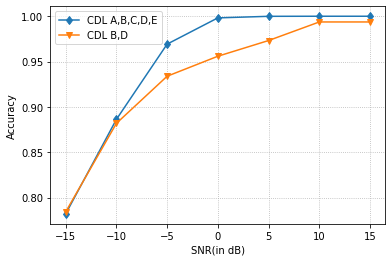

In [5]:
SNR_vec = range(-15,20,5)
plt.plot(SNR_vec,1 - error_v1.T,'d-',label='CDL A,B,C,D,E')
plt.plot(SNR_vec,1 - error,'v-',label='CDL B,D')
plt.xlabel('SNR(in dB)')
plt.ylabel('Accuracy')
plt.grid(ls=':')
plt.legend()
plt.savefig('results/LOS_Predictor.pdf',dpi=5000)

In [3]:
error_v1 = np.array([[2.17960784e-01, 1.13725490e-01, 3.07450980e-02, 1.80392157e-03,
  7.84313725e-05, 0.00000000e+00, 0.00000000e+00]])
error_v2 = np.array([[[0.22519685],[0.14173228],[0.10551181],[0.06771654],[0.03307087],[0.00629921],[0.0015748 ]]])

In [2]:
error = np.array([[0.21574803],[0.11811024],[0.06614173],[0.04409449],[0.02677165],[0.00629921],[0.00629921]])